# Week 4: Using real world data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-10-10 16:10:04.140393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 16:10:04.211052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 16:10:04.244054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 16:10:04.253346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 16:10:04.294724: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import unittests

Begin by looking at the structure of the csv that contains the data:

In [2]:
DATA_PATH = './data/daily-min-temperatures.csv'

with open(DATA_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

### Exercise 1: parse_data_from_file

Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You are encouraged to use the function [`np.loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) to load the data. Make sure to check out the documentation to learn about useful parameters. 
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. Make sure to select the correct column to read with `np.loadtxt`.

In [4]:
# GRADED FUNCTION: parse_data
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """    
    ### START CODE HERE
    # Load the temperatures using np.loadtxt. Remember you want to skip the first 
    # row, since it's headers. Make sure to use the correct column of the csv file.
    temperatures = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=1)
    times = np.arange(len(temperatures))
    ### END CODE HERE
        
    return times, temperatures

Now, use this function to create the timestamps, `TIME`, and the time series, `SERIES`

In [5]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

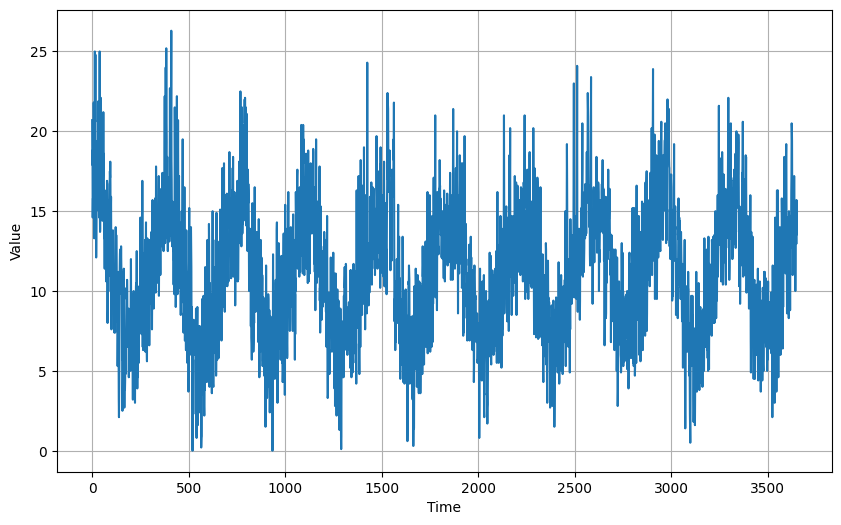

In [6]:
# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

**Expected Output:**
<div>
<img src="images/temp-series.png" width="650"/>
</div>

In [ ]:
# Test your code!
unittests.test_parse_data_from_file(parse_data_from_file)

## Defining some useful global variables

Next, you will define some global variables that will come used throughout the assignment. Feel free to reference them in the upcoming exercises:


`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length od the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.** 

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

In [7]:
# Save all global variables
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you. Notice that like in week 3, the `windowed_dataset` function has an extra step, which expands the series to have an extra dimension. This is done because you will be working with Conv layers which expect the dimensionality of its inputs to be 3 (including the batch dimension).

In [8]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [9]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [10]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [11]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

I0000 00:00:1728587430.601116  335661 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728587430.784543  335661 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728587430.784595  335661 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728587430.788393  335661 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728587430.788425  335661 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Defining the model architecture

### Exercise 2: create_uncompiled_model

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your model architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

**Hint:**

- Remember that the original dataset was expanded, so account for this when setting the shape of the `tf.keras.Input`

- No `Lambda` layers are required
- Use a combination of `Conv1D` and `LSTM` layers, followed by `Dense`.

In [12]:
# GRADED FUNCTION: create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """
    ### START CODE HERE ###
    
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(WINDOW_SIZE, 1)), # Set the correct input shape for the model
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
		
    ]) 
    
    ### END CODE HERE ###
    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [13]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [ ]:
# Check the parameter count against a reference solution
unittests.parameter_count(uncompiled_model)

In [14]:
example_batch = train_dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

2024-10-10 16:11:05.754958: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728587465.813175  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.831490  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.839053  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.851478  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.859564  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.868104  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.876360  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.883977  335954 gpu_t

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (256, 1)


W0000 00:00:1728587465.957649  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.967636  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.975465  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.985442  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587465.995901  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587466.004829  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587466.007699  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587466.010422  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587466.019627  335954 gp

**Expected output:**

```
Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (NUM_BATCHES, 1)
```
Where `NUM_BATCHES` is the number of batches you have set to your dataset.

In [ ]:
# Test your code!
unittests.test_create_uncompiled_model(create_uncompiled_model)

You can also print a summary of your model to see what the architecture looks like. This can be useful to get a sense of how big your model is.

In [15]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures, you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand. This is the same function you had on Week 3 Assignment, feel free to reuse it.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [16]:
def adjust_learning_rate(dataset):
    """Fit model using different learning rates

    Args:
        dataset (tf.data.Dataset): train dataset

    Returns:
        tf.keras.callbacks.History: callback history
    """

    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
    
    ### START CODE HERE ###
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE ###

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [17]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_dataset)

Epoch 1/100


W0000 00:00:1728587476.870590  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.917611  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.924984  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.932313  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.939639  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.947011  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.955081  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.962520  335952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587476.975246  335952 gp

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.3219 - mae: 10.8209 - learning_rate: 1.0000e-05
Epoch 2/100


W0000 00:00:1728587478.274228  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.275397  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.276332  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.277267  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.278256  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.279175  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.280162  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.281114  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587478.282101  335954 gp

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2716 - mae: 10.7703 - learning_rate: 1.1220e-05
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 10.0920 - mae: 10.5919

2024-10-10 16:11:18.753427: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:11:18.753486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:18.753502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:18.753506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.1931 - mae: 10.6922 - learning_rate: 1.2589e-05
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 10.2163 - mae: 10.7130

2024-10-10 16:11:19.141416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:19.141467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:19.141473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10.3356 - mae: 10.8340 - learning_rate: 1.4125e-05
Epoch 5/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 10.5407 - mae: 11.0407

2024-10-10 16:11:19.544681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:11:19.544729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:19.544745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:19.544749: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.3209 - mae: 10.8203 - learning_rate: 1.5849e-05
Epoch 6/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 10.1477 - mae: 10.6475

2024-10-10 16:11:19.935119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:19.935178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:19.935185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2230 - mae: 10.7218 - learning_rate: 1.7783e-05
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 10.2076 - mae: 10.7073

2024-10-10 16:11:20.333668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:20.333721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:20.333728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.1500 - mae: 10.6490 - learning_rate: 1.9953e-05
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 10.5384 - mae: 11.0384

2024-10-10 16:11:20.721412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:20.721470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:20.721476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10.2154 - mae: 10.7143 - learning_rate: 2.2387e-05
Epoch 9/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 10.4320 - mae: 10.9302

2024-10-10 16:11:21.122475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:11:21.122527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:21.122543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:21.122547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 10.1452 - mae: 10.6439 - learning_rate: 2.5119e-05
Epoch 10/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 10.0038 - mae: 10.5026

2024-10-10 16:11:21.560286: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:21.560346: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:21.560356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:21.560362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:21.560368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.0586 - mae: 10.5575 - learning_rate: 2.8184e-05
Epoch 11/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 10.1183 - mae: 10.6169

2024-10-10 16:11:21.948214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:21.948285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:21.948293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.0443 - mae: 10.5428 - learning_rate: 3.1623e-05
Epoch 12/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 10.4330 - mae: 10.9326

2024-10-10 16:11:22.337771: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:22.337820: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:22.337830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:22.337835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:22.337839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 10.0657 - mae: 10.5641 - learning_rate: 3.5481e-05
Epoch 13/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 9.8896 - mae: 10.3896

2024-10-10 16:11:22.762364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:22.762414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:22.762422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.9032 - mae: 10.4018 - learning_rate: 3.9811e-05
Epoch 14/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 10.2210 - mae: 10.7210

2024-10-10 16:11:23.151818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:23.151867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:23.151874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.9134 - mae: 10.4119 - learning_rate: 4.4668e-05
Epoch 15/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 10.4000 - mae: 10.8985

2024-10-10 16:11:23.554543: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:23.554585: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:23.554594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:23.554599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:23.554603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.9786 - mae: 10.4770 - learning_rate: 5.0119e-05
Epoch 16/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 10.3046 - mae: 10.8028

2024-10-10 16:11:23.958768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:23.958820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:23.958828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.9642 - mae: 10.4627 - learning_rate: 5.6234e-05
Epoch 17/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 9.9111 - mae: 10.4088

2024-10-10 16:11:24.348514: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:11:24.348564: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:24.348571: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:24.348577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:24.348581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:24.348585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.8696 - mae: 10.3677 - learning_rate: 6.3096e-05
Epoch 18/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 10.0640 - mae: 10.5623

2024-10-10 16:11:24.767957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:24.768008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:24.768015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.8391 - mae: 10.3375 - learning_rate: 7.0795e-05
Epoch 19/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 9.8943 - mae: 10.3936

2024-10-10 16:11:25.176404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:25.176456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:25.176462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.7428 - mae: 10.2415 - learning_rate: 7.9433e-05
Epoch 20/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 9.7023 - mae: 10.2003

2024-10-10 16:11:25.585829: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:25.585872: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:25.585880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:25.585885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:25.585889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.6697 - mae: 10.1683 - learning_rate: 8.9125e-05
Epoch 21/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 9.5604 - mae: 10.0592

2024-10-10 16:11:26.003945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:26.003991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:26.003997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.5340 - mae: 10.0327 - learning_rate: 1.0000e-04
Epoch 22/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 9.8332 - mae: 10.3329

2024-10-10 16:11:26.398388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:26.398431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:26.398438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.5630 - mae: 10.0610 - learning_rate: 1.1220e-04
Epoch 23/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 9.4831 - mae: 9.9831

2024-10-10 16:11:26.818262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:26.818333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:26.818340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.4270 - mae: 9.9254 - learning_rate: 1.2589e-04
Epoch 24/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 10.0728 - mae: 10.5721

2024-10-10 16:11:27.236176: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:27.236222: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:27.236231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:27.236235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:27.236240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.3903 - mae: 9.8887 - learning_rate: 1.4125e-04
Epoch 25/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 9.3919 - mae: 9.8889

2024-10-10 16:11:27.645464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:27.645523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:27.645530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.1484 - mae: 9.6465 - learning_rate: 1.5849e-04
Epoch 26/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 9.0292 - mae: 9.5239

2024-10-10 16:11:28.040407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:28.040457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:28.040464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.9986 - mae: 9.4963 - learning_rate: 1.7783e-04
Epoch 27/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 9.0177 - mae: 9.5177

2024-10-10 16:11:28.476812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:28.476873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:28.476880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.7831 - mae: 9.2815 - learning_rate: 1.9953e-04
Epoch 28/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 8.5915 - mae: 9.0911

2024-10-10 16:11:28.877114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:28.877167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:28.877174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4894 - mae: 8.9875 - learning_rate: 2.2387e-04
Epoch 29/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 8.1864 - mae: 8.6853

2024-10-10 16:11:29.280236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:29.280286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:29.280295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.0640 - mae: 8.5614 - learning_rate: 2.5119e-04
Epoch 30/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 7.5907 - mae: 8.0871

2024-10-10 16:11:29.693889: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:29.693955: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:29.693966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:29.693970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:29.693975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.5023 - mae: 7.9979 - learning_rate: 2.8184e-04
Epoch 31/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 7.4765 - mae: 7.9727

2024-10-10 16:11:30.089035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:30.089084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:30.089090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.8076 - mae: 7.3026 - learning_rate: 3.1623e-04
Epoch 32/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 6.1337 - mae: 6.6191

2024-10-10 16:11:30.493065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:30.493115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:30.493121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5423 - mae: 6.0293 - learning_rate: 3.5481e-04
Epoch 33/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 4.5274 - mae: 5.0086

2024-10-10 16:11:30.899410: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:11:30.899469: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:30.899476: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:30.899483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:30.899488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:30.899493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0358 - mae: 4.5122 - learning_rate: 3.9811e-04
Epoch 34/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 3.0472 - mae: 3.5244

2024-10-10 16:11:31.299883: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:31.299930: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:31.299940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:31.299944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:31.299948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7944 - mae: 3.2648 - learning_rate: 4.4668e-04
Epoch 35/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 2.5913 - mae: 3.0581

2024-10-10 16:11:31.701063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:31.701112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:31.701119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.6288 - mae: 3.0956 - learning_rate: 5.0119e-04
Epoch 36/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 2.4423 - mae: 2.9062

2024-10-10 16:11:32.116299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:32.116350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:32.116358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4932 - mae: 2.9593 - learning_rate: 5.6234e-04
Epoch 37/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 2.7854 - mae: 3.2409

2024-10-10 16:11:32.522445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:32.522496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:32.522502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.5425 - mae: 3.0033 - learning_rate: 6.3096e-04
Epoch 38/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 2.5028 - mae: 2.9561

2024-10-10 16:11:32.920507: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:32.920556: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:32.920566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:32.920570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:32.920574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.3738 - mae: 2.8337 - learning_rate: 7.0795e-04
Epoch 39/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 2.1188 - mae: 2.5822

2024-10-10 16:11:33.319003: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:33.319052: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:33.319061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:33.319065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:33.319069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1664 - mae: 2.6258 - learning_rate: 7.9433e-04
Epoch 40/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 2.1372 - mae: 2.5980

2024-10-10 16:11:33.720942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:33.721028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:33.721062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1700 - mae: 2.6279 - learning_rate: 8.9125e-04
Epoch 41/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 2.2312 - mae: 2.6912

2024-10-10 16:11:34.155778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:34.155824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:34.155832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1668 - mae: 2.6230 - learning_rate: 0.0010
Epoch 42/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 2.1076 - mae: 2.5705

2024-10-10 16:11:34.559975: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:34.560028: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:34.560040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:34.560047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:34.560053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9628 - mae: 2.4169 - learning_rate: 0.0011
Epoch 43/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 1.8709 - mae: 2.3095

2024-10-10 16:11:34.973825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:34.973876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:34.973882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8869 - mae: 2.3360 - learning_rate: 0.0013
Epoch 44/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 2.2925 - mae: 2.7577

2024-10-10 16:11:35.388089: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:35.388133: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:35.388141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:35.388145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:35.388149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0916 - mae: 2.5509 - learning_rate: 0.0014
Epoch 45/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.9422 - mae: 2.4003

2024-10-10 16:11:35.779827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:35.779878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:35.779885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9242 - mae: 2.3796 - learning_rate: 0.0016
Epoch 46/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.8785 - mae: 2.3262

2024-10-10 16:11:36.171342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:36.171393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:36.171400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8203 - mae: 2.2745 - learning_rate: 0.0018
Epoch 47/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 2.0064 - mae: 2.4656

2024-10-10 16:11:36.571858: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:36.571905: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:36.571914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:36.571920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:36.571924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.9106 - mae: 2.3681 - learning_rate: 0.0020
Epoch 48/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 1.9990 - mae: 2.4543

2024-10-10 16:11:37.006969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:37.007068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:37.007075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8765 - mae: 2.3325 - learning_rate: 0.0022
Epoch 49/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.9617 - mae: 2.4163

2024-10-10 16:11:37.385891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:37.385948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:37.385955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8653 - mae: 2.3203 - learning_rate: 0.0025
Epoch 50/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 1.9118 - mae: 2.3663

2024-10-10 16:11:37.768228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:37.768288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:37.768299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8103 - mae: 2.2600 - learning_rate: 0.0028
Epoch 51/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.8054 - mae: 2.2574

2024-10-10 16:11:38.163046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:38.163106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:38.163113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8023 - mae: 2.2534 - learning_rate: 0.0032
Epoch 52/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 1.9149 - mae: 2.3720

2024-10-10 16:11:38.566698: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:38.566746: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:38.566754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:38.566758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:38.566762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7114 - mae: 2.1601 - learning_rate: 0.0035
Epoch 53/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.7132 - mae: 2.1680

2024-10-10 16:11:38.971868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:38.971920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:38.971927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7042 - mae: 2.1522 - learning_rate: 0.0040
Epoch 54/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.7956 - mae: 2.2461

2024-10-10 16:11:39.366376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:39.366435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:39.366444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6945 - mae: 2.1367 - learning_rate: 0.0045
Epoch 55/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 1.7710 - mae: 2.2107

2024-10-10 16:11:39.776358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:39.776424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:39.776432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7938 - mae: 2.2441 - learning_rate: 0.0050
Epoch 56/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.7479 - mae: 2.1973

2024-10-10 16:11:40.203074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:40.203124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:40.203131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6527 - mae: 2.0996 - learning_rate: 0.0056
Epoch 57/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 1.5444 - mae: 1.9840

2024-10-10 16:11:40.602816: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:40.602864: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:40.602873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:40.602878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:40.602882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5640 - mae: 2.0083 - learning_rate: 0.0063
Epoch 58/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.8369 - mae: 2.2918

2024-10-10 16:11:40.992491: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:40.992537: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:40.992545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:40.992549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:40.992554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7211 - mae: 2.1712 - learning_rate: 0.0071
Epoch 59/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 2.2745 - mae: 2.7327

2024-10-10 16:11:41.394442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:41.394499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:41.394519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722
2024-10-10 16:11:41.394540: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8635 - mae: 2.3146 - learning_rate: 0.0079
Epoch 60/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 1.7783 - mae: 2.2320

2024-10-10 16:11:41.800191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:41.800240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:41.800248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8956 - mae: 2.3553 - learning_rate: 0.0089
Epoch 61/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.5678 - mae: 2.0121

2024-10-10 16:11:42.219051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:42.219109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:42.219119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8332 - mae: 2.2873 - learning_rate: 0.0100
Epoch 62/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 1.7784 - mae: 2.2226

2024-10-10 16:11:42.637193: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:42.637243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:42.637250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6889 - mae: 2.1358 - learning_rate: 0.0112
Epoch 63/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 1.5374 - mae: 1.9774

2024-10-10 16:11:43.092168: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:43.092216: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:43.092225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:43.092229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:43.092233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6891 - mae: 2.1354 - learning_rate: 0.0126
Epoch 64/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.7625 - mae: 2.2255

2024-10-10 16:11:43.487083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:43.487135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:43.487142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8649 - mae: 2.3225 - learning_rate: 0.0141
Epoch 65/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 1.8331 - mae: 2.2804

2024-10-10 16:11:43.886229: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:11:43.886283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:43.886289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:43.886294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7498 - mae: 2.2022 - learning_rate: 0.0158
Epoch 66/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.6710 - mae: 2.1177

2024-10-10 16:11:44.301990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:44.302038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:44.302044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7334 - mae: 2.1855 - learning_rate: 0.0178
Epoch 67/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.6624 - mae: 2.1047

2024-10-10 16:11:44.705447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:44.705498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:44.705505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6420 - mae: 2.0892 - learning_rate: 0.0200
Epoch 68/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 1.5895 - mae: 2.0257

2024-10-10 16:11:45.108750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:45.108831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:45.108863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9563 - mae: 2.4060 - learning_rate: 0.0224
Epoch 69/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 2.1019 - mae: 2.5640

2024-10-10 16:11:45.503206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:45.503259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:45.503266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.8762 - mae: 2.3323 - learning_rate: 0.0251
Epoch 70/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.7921 - mae: 2.2505

2024-10-10 16:11:45.937799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:45.937839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:45.937846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.9767 - mae: 2.4355 - learning_rate: 0.0282
Epoch 71/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 2.2826 - mae: 2.7523

2024-10-10 16:11:46.368786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:46.368829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:46.368836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0605 - mae: 2.5177 - learning_rate: 0.0316
Epoch 72/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 2.1281 - mae: 2.5909

2024-10-10 16:11:46.773430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:46.773484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:46.773490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8399 - mae: 2.2936 - learning_rate: 0.0355
Epoch 73/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.7167 - mae: 2.1625

2024-10-10 16:11:47.169306: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:47.169364: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:47.169374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:47.169379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:47.169383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7321 - mae: 2.1778 - learning_rate: 0.0398
Epoch 74/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 2.2390 - mae: 2.7052

2024-10-10 16:11:47.586894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:47.586943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:47.586950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4078 - mae: 2.8759 - learning_rate: 0.0447
Epoch 75/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 2.6127 - mae: 3.0825

2024-10-10 16:11:47.986187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:47.986241: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:47.986247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.4141 - mae: 2.8773 - learning_rate: 0.0501
Epoch 76/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.6664 - mae: 2.1122

2024-10-10 16:11:48.399380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:48.399419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:48.399426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.1846 - mae: 2.6454 - learning_rate: 0.0562
Epoch 77/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ -3s -352839us/step - loss: 2.5011 - mae: 2.9689

2024-10-10 16:11:48.809089: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:48.809143: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:48.809154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:48.809160: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:48.809164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ -0s 31ms/step - loss: 2.0453 - mae: 2.5059 - learning_rate: 0.0631
Epoch 78/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.8085 - mae: 2.2522

2024-10-10 16:11:48.741130: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:48.741189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:48.741208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:48.741213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.9410 - mae: 2.3928 - learning_rate: 0.0708
Epoch 79/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.6526 - mae: 2.1018

2024-10-10 16:11:49.176928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:49.176976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:49.176983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.8307 - mae: 3.2986 - learning_rate: 0.0794
Epoch 80/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 1.9317 - mae: 2.3901

2024-10-10 16:11:49.597068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:49.597112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:49.597119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.6678 - mae: 3.1311 - learning_rate: 0.0891
Epoch 81/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 2.9460 - mae: 3.4083

2024-10-10 16:11:50.026562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:50.026632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:50.026640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.9534 - mae: 3.4198 - learning_rate: 0.1000
Epoch 82/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 3.2350 - mae: 3.7116

2024-10-10 16:11:50.436680: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:50.436731: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:50.436741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:50.436745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:50.436749: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.9600 - mae: 3.4324 - learning_rate: 0.1122
Epoch 83/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 3.0838 - mae: 3.5580

2024-10-10 16:11:50.848911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:50.848965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:50.848972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.8105 - mae: 3.2780 - learning_rate: 0.1259
Epoch 84/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 2.8828 - mae: 3.3529

2024-10-10 16:11:51.249582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:51.249633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:51.249641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7949 - mae: 3.2621 - learning_rate: 0.1413
Epoch 85/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 3.0326 - mae: 3.5116

2024-10-10 16:11:51.646249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:51.646297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:51.646313: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.8989 - mae: 3.3707 - learning_rate: 0.1585
Epoch 86/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 3.0316 - mae: 3.5002

2024-10-10 16:11:52.065436: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:52.065490: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:52.065500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:52.065507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:52.065513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.9168 - mae: 3.3865 - learning_rate: 0.1778
Epoch 87/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 2.8156 - mae: 3.2849

2024-10-10 16:11:52.500093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:52.500140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:52.500146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8326 - mae: 3.3042 - learning_rate: 0.1995
Epoch 88/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 3.0194 - mae: 3.4916

2024-10-10 16:11:52.909007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:52.909056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:52.909063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8328 - mae: 3.3024 - learning_rate: 0.2239
Epoch 89/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 2.9335 - mae: 3.4079

2024-10-10 16:11:53.324438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:53.324486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:53.324493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8351 - mae: 3.3056 - learning_rate: 0.2512
Epoch 90/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 2.8639 - mae: 3.3386

2024-10-10 16:11:53.714773: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:53.714818: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:53.714826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:53.714831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:53.714834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.8250 - mae: 3.2940 - learning_rate: 0.2818
Epoch 91/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 3.1083 - mae: 3.5786

2024-10-10 16:11:54.153429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:54.153472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:54.153479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8290 - mae: 3.2944 - learning_rate: 0.3162
Epoch 92/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 2.9049 - mae: 3.3704

2024-10-10 16:11:54.560664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:54.560718: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:54.560725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.9347 - mae: 3.4045 - learning_rate: 0.3548
Epoch 93/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 3.0358 - mae: 3.4977

2024-10-10 16:11:54.952820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:54.952868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:54.952875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.9315 - mae: 3.3995 - learning_rate: 0.3981
Epoch 94/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 2.9705 - mae: 3.4405

2024-10-10 16:11:55.346970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:55.347021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:55.347028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8296 - mae: 3.2998 - learning_rate: 0.4467
Epoch 95/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 2.8000 - mae: 3.2659

2024-10-10 16:11:55.731116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:55.731170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:55.731177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7928 - mae: 3.2620 - learning_rate: 0.5012
Epoch 96/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 2.9172 - mae: 3.3891

2024-10-10 16:11:56.131653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:56.131707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:56.131715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8197 - mae: 3.2872 - learning_rate: 0.5623
Epoch 97/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 2.9309 - mae: 3.3986

2024-10-10 16:11:56.528790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:56.528844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:56.528851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.8114 - mae: 3.2779 - learning_rate: 0.6310
Epoch 98/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 2.9755 - mae: 3.4561

2024-10-10 16:11:56.944226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:56.944278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:56.944287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.8736 - mae: 3.3456 - learning_rate: 0.7079
Epoch 99/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 2.9975 - mae: 3.4684

2024-10-10 16:11:57.344905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:57.344956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:57.344962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.9081 - mae: 3.3798 - learning_rate: 0.7943
Epoch 100/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 3.0514 - mae: 3.5231

2024-10-10 16:11:57.743307: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:11:57.743356: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:11:57.743365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:57.743370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:57.743374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.8833 - mae: 3.3496 - learning_rate: 0.8913


2024-10-10 16:11:58.152303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:11:58.152354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:11:58.152361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


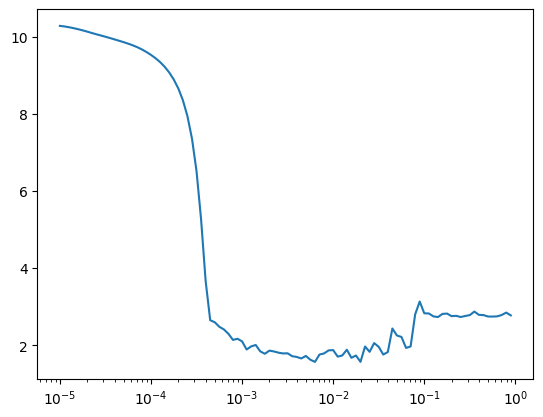

In [18]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

## Compiling the model

### Exercise 3: create_model

Now, it is time to do the actual training that will be used to forecast the time series. For this, complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate). If you completed the optional exercise, you should have a better idea of what a good learning rate would be.

**Hints:**

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [19]:
# GRADED FUNCTION: create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    
    model = create_uncompiled_model()

    ### START CODE HERE ###

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=10e-4, momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE ###

    return model

In [20]:
# Save an instance of the model
model = create_model()

In [ ]:
# Test your code!
unittests.test_create_model(create_model)

If you passed the unittests, go ahead and train your model by running the cell below:

In [21]:
# Train it
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 9.8749 - mae: 10.3739
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 9.0437 - mae: 9.5411

2024-10-10 16:12:31.142366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.0596 - mae: 8.5569
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 6.2365 - mae: 6.7243

2024-10-10 16:12:31.537787: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:31.537844: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:31.537852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:31.537857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:31.537861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8280 - mae: 5.3098
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 2.7683 - mae: 3.2405

2024-10-10 16:12:31.928642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:31.928686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:31.928692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.9238 - mae: 3.3974
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 3.1470 - mae: 3.6197

2024-10-10 16:12:32.311926: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:32.311971: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:32.311979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:32.311983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:32.311987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.7346 - mae: 3.2040
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 2.6132 - mae: 3.0780

2024-10-10 16:12:32.729535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:32.729590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:32.729597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.6664 - mae: 3.1311
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.5260 - mae: 2.9893
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 2.6923 - mae: 3.1593

2024-10-10 16:12:33.522790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:33.522862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4443 - mae: 2.9068
Epoch 9/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 2.3095 - mae: 2.7844

2024-10-10 16:12:33.929325: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:33.929366: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:33.929376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:33.929380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:33.929384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.2229 - mae: 2.6833
Epoch 10/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.9187 - mae: 2.3749

2024-10-10 16:12:34.351470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9320 - mae: 2.3832
Epoch 11/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.9953 - mae: 2.4561

2024-10-10 16:12:34.748832: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:34.748878: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:34.748887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:34.748891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:34.748895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8840 - mae: 2.3372
Epoch 12/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 1.9158 - mae: 2.3793

2024-10-10 16:12:35.148323: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:35.148371: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:35.148380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:35.148385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:35.148389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8620 - mae: 2.3143
Epoch 13/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.9363 - mae: 2.3850

2024-10-10 16:12:35.531595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:35.531644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:35.531650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9541 - mae: 2.4027
Epoch 14/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.8209 - mae: 2.2804

2024-10-10 16:12:35.938056: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:35.938105: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:35.938113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:35.938117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:35.938121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8056 - mae: 2.2586
Epoch 15/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.9824 - mae: 2.4360

2024-10-10 16:12:36.339481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:36.339529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:36.339536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8752 - mae: 2.3273
Epoch 16/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 1.8620 - mae: 2.3154

2024-10-10 16:12:36.757468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:36.757512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:36.757519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7894 - mae: 2.2404
Epoch 17/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 1.7865 - mae: 2.2406

2024-10-10 16:12:37.169654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:37.169699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:37.169706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7908 - mae: 2.2416
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8148 - mae: 2.2676
Epoch 19/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.7613 - mae: 2.2151

2024-10-10 16:12:37.979129: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:37.979179: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:37.979188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:37.979192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:37.979196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7688 - mae: 2.2196
Epoch 20/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.8471 - mae: 2.2953

2024-10-10 16:12:38.425348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:38.425393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:38.425399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7880 - mae: 2.2411
Epoch 21/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 2.0247 - mae: 2.4858

2024-10-10 16:12:38.826437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:38.826489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:38.826496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8030 - mae: 2.2546
Epoch 22/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 1.7630 - mae: 2.2147

2024-10-10 16:12:39.231896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:39.231944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:39.231951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7521 - mae: 2.2033
Epoch 23/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 1.7638 - mae: 2.2169

2024-10-10 16:12:39.647984: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:39.648032: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:39.648041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:39.648046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:39.648050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7420 - mae: 2.1933
Epoch 24/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 1.8260 - mae: 2.2788

2024-10-10 16:12:40.076234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:40.076281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:40.076288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7686 - mae: 2.2199
Epoch 25/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.8564 - mae: 2.3103

2024-10-10 16:12:40.474747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:40.474793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:40.474799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7588 - mae: 2.2124
Epoch 26/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 1.7488 - mae: 2.2008

2024-10-10 16:12:40.885156: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:40.885207: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:40.885216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:40.885220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:40.885225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7344 - mae: 2.1884
Epoch 27/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 1.8111 - mae: 2.2685

2024-10-10 16:12:41.302227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:41.302279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:41.302286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7248 - mae: 2.1767
Epoch 28/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 1.8496 - mae: 2.3078

2024-10-10 16:12:41.707953: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:41.708007: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:41.708018: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:41.708022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:41.708026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7240 - mae: 2.1765
Epoch 29/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.6915 - mae: 2.1439

2024-10-10 16:12:42.131593: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 16:12:42.131665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:42.131684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:42.131688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7029 - mae: 2.1543
Epoch 30/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 1.8089 - mae: 2.2618

2024-10-10 16:12:42.549344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:42.549402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:42.549409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7386 - mae: 2.1899
Epoch 31/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.8502 - mae: 2.3060

2024-10-10 16:12:42.967709: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:42.967762: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:42.967773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:42.967779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:42.967785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7232 - mae: 2.1755
Epoch 32/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.7626 - mae: 2.2130

2024-10-10 16:12:43.390948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:43.391005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:43.391011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.6789 - mae: 2.1258
Epoch 33/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 2.0084 - mae: 2.4625

2024-10-10 16:12:43.817753: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:43.817804: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:43.817813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:43.817817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:43.817821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7420 - mae: 2.1938
Epoch 34/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.5736 - mae: 2.0127

2024-10-10 16:12:44.251497: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:44.251547: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:44.251556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:44.251559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:44.251564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6808 - mae: 2.1295
Epoch 35/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 1.6729 - mae: 2.1249

2024-10-10 16:12:44.640340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:44.640395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:44.640402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6783 - mae: 2.1273
Epoch 36/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.6749 - mae: 2.1210

2024-10-10 16:12:45.036651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:45.036714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:45.036722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6849 - mae: 2.1317
Epoch 37/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.7069 - mae: 2.1538

2024-10-10 16:12:45.431092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:45.431136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6339 - mae: 2.0809
Epoch 38/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 1.6158 - mae: 2.0620

2024-10-10 16:12:45.833038: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:45.833086: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:45.833095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:45.833100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:45.833105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6282 - mae: 2.0742
Epoch 39/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.6535 - mae: 2.1001

2024-10-10 16:12:46.251447: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:46.251492: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:46.251501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:46.251505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:46.251509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6682 - mae: 2.1169
Epoch 40/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.6923 - mae: 2.1362

2024-10-10 16:12:46.639845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:46.639896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:46.639903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6340 - mae: 2.0784
Epoch 41/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.7002 - mae: 2.1597

2024-10-10 16:12:47.051111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:47.051160: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:47.051167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6476 - mae: 2.0973
Epoch 42/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 1.6285 - mae: 2.0805

2024-10-10 16:12:47.485775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:47.485819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:47.485826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5965 - mae: 2.0447
Epoch 43/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 1.6103 - mae: 2.0571

2024-10-10 16:12:47.883680: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:47.883734: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:47.883743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:47.883747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:47.883752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6060 - mae: 2.0505
Epoch 44/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 1.6422 - mae: 2.0895

2024-10-10 16:12:48.284819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:48.284869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:48.284876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6836 - mae: 2.1326
Epoch 45/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.6475 - mae: 2.0949
Epoch 46/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.6996 - mae: 2.1451

2024-10-10 16:12:49.104695: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:49.104744: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:49.104754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:49.104759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:49.104764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6629 - mae: 2.1092
Epoch 47/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.5657 - mae: 2.0152

2024-10-10 16:12:49.496564: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:49.496616: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:49.496625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:49.496631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:49.496634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5722 - mae: 2.0170
Epoch 48/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.7366 - mae: 2.1828

2024-10-10 16:12:49.889136: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11271272746754951405
2024-10-10 16:12:49.889180: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6194234069849789639
2024-10-10 16:12:49.889189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:49.889194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:49.889198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5855 - mae: 2.0298
Epoch 49/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.5837 - mae: 2.0245

2024-10-10 16:12:50.299102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:50.299146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:50.299153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5649 - mae: 2.0073
Epoch 50/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 1.6772 - mae: 2.1239

2024-10-10 16:12:50.700210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:50.700253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:50.700259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5738 - mae: 2.0180


2024-10-10 16:12:51.112328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3960675969414727706
2024-10-10 16:12:51.112375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12121543135773648566
2024-10-10 16:12:51.112382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9251033035074940722


Now plot the training loss so you can monitor the learning process.

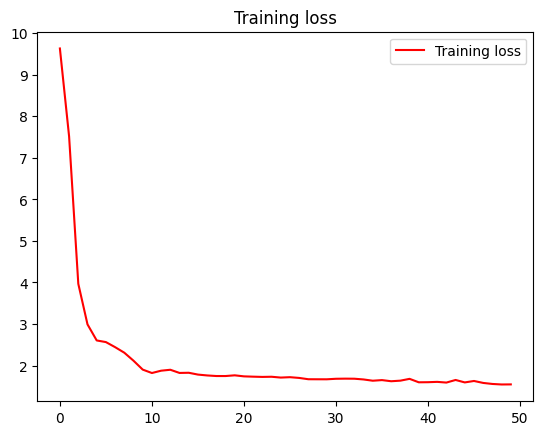

In [22]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [23]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous weeks you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [24]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

W0000 00:00:1728587588.308734  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.316374  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.323293  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.330337  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.337326  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.344330  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.351367  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.358340  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.365356  335954 gp

     30/Unknown 1s 5ms/step

W0000 00:00:1728587588.517069  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.521560  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.524122  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.525502  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


W0000 00:00:1728587588.851760  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.853253  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.854553  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.855805  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.857033  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.858166  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.859293  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.860393  335954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728587588.861453  335954 gp

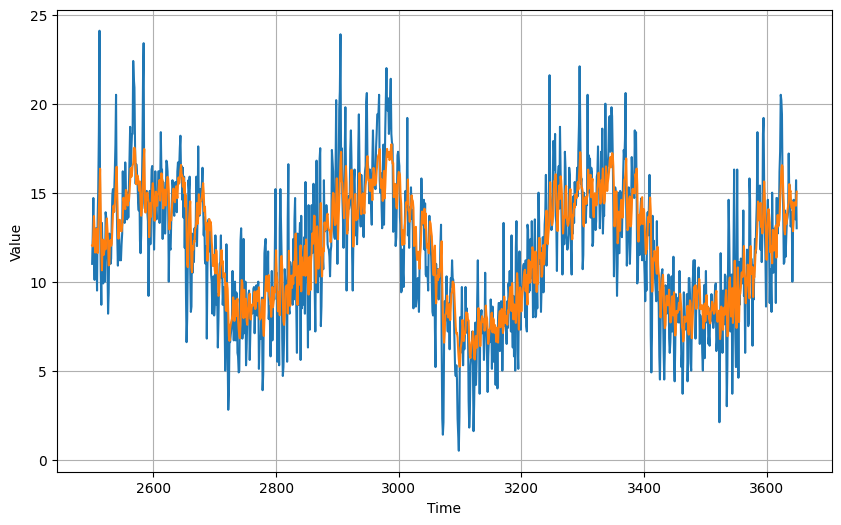

In [26]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [27]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.56, mae: 1.83 for forecast


**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.

If your forecast did achieve these thresholds run the following cell to save the metrics in a binary file which will be used for grading. After doing so, submit your assignment for grading.

In [ ]:
# Save metrics into a dictionary
metrics_dict = {
    "mse": float(mse),
    "mae": float(mae)
}

# Save your metrics in a binary file 
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**